<a href="https://colab.research.google.com/github/AlbertVong/Deep-Learning-Notes/blob/main/micrograd_demo_three_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing micrograd from scratch and using it for a 3 class classification problem (harder than a binary classification problem). This creates a 2D decision boundary.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
import math

In [ ]:
from sklearn import datasets

We'll be using a multi-moon dataset (more than the binary classification problem that is in the original demo, just to make it a tiny bit harder).

Answer taken from here: https://stackoverflow.com/questions/71733603/generate-a-dataset-distributed-in-three-interleaving-half-circle-shape-in-python

In [ ]:
def make_many_moons(
    number_of_moons,
    sigma, 
    radius, 
    number_of_datapoints,
    y_shift = 0.3
):
    
    moons = []
    for y in range(number_of_moons):
        q = np.random.uniform(0,np.pi,size=number_of_datapoints)
        
        #Whether moon curves up or down
        if y % 2 == 0:
            factor = 1
        else: 
            factor = -1
        
        moon = np.zeros((number_of_datapoints, 3))
        #x val
        moon[:,0] = (radius * np.cos(q)) + y
        #y val
        moon[:,1] = (radius * np.sin(q) * factor) + (factor == -1) * y_shift
        #Which moon this belongs to
        moon[:,2] = y
        moons.append(moon)
        noise = np.random.normal(0, sigma, size=moon[:,:2].shape)
        moon[:,:2] += noise
    moons = np.concatenate(moons)
    return moons[:,:2], moons[:,2]

In [ ]:
x_raw, label = make_many_moons(
    number_of_moons = 3,
    sigma = 0.1,
    radius = 1,
    number_of_datapoints=40,
    y_shift = 0.3
)

In [ ]:
#Convert labels to int (For indexing later)
label_i = label.astype(int)

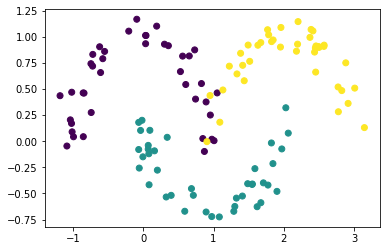

In [ ]:
plt.scatter(x_raw[:,0], x_raw[:,1], c = label)

In [ ]:
from sklearn.datasets import make_moons, make_blobs

In [ ]:
Xtest, ytest = make_moons(n_samples=100, noise=0.1)

In [ ]:
x_all = x_raw
x_all[:,0] = (x_raw[:,0] - np.mean(x_raw[:,0])) / np.std(x_raw[:,0])
x_all[:,1] = (x_raw[:,1] - np.mean(x_raw[:,1])) / np.std(x_raw[:,1]) 

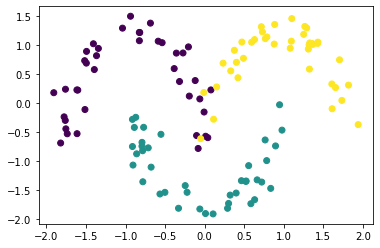

In [ ]:
plt.scatter(x_all[:,0], x_all[:,1], c = label)

# Reimporting Value, MLP, etc.

The reason why we can't directly import micrograd's methods is because we've slightly rewritten "Value" to include exponentials for the purpose of using softmax for 3 class classification. Since the neural net methods are written off of the "Value" class in engine.py, we need to redefine everything from scratch so there are no bad references to the wrong Value function

In [ ]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def max_param(self):
        param_vals = [p.data for p in self.parameters()]
        return max(param_vals)

    def max_grad(self):
        param_vals = [p.grad for p in self.parameters()]
        return max(param_vals)

    def parameters(self):
        return []


class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.gauss(0, 0.25)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [ ]:
#Redefine "Value", since we need to include the exponential function in it.
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0
        self.label = label
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def exp(self):
      self = self if isinstance(self, Value) else Value(self)
      x = self.data
      e = math.exp(x)
      out = Value(e, (self, ), 'exp')

      def _backward():
        self.grad += e**x * out.grad
      out._backward = _backward

      return out

    def log(self):
      self = self if isinstance(self, Value) else Value(self)
      eps = 1e-4 #numerical stability
      x = self.data + eps
      y = math.log(x)
      out = Value(y, (self, ), 'log')

      def _backward():
        self.grad += 1/x * out.grad
      out._backward = _backward

      return out

    def logistic(self):
      self = self if isinstance(self, Value) else Value(self)
      x = self.data
      y = 1 / (1 + math.exp(-x))
      out = Value(y, (self, ), 'logistic')

      def _backward():
        self.grad += math.exp(-x) / (1 + math.exp(-x))**2 * out.grad
      out._backward = _backward

      return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [ ]:
from graphviz import Digraph

In [ ]:
def trace(root):
  #builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

In [ ]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR means left to right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    #for value in graph, create rectangular ('record) node for it
    dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      #if this value is the result of some operation, create op node
      dot.node(name = uid + n._op, label = n._op)
      #connect the node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    #Connect n1 to op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)


  return dot

# Model Work Below

In [ ]:
#Define our simple 3 layer MLP
model = MLP(2,[20, 20, 3]) #2 layer network
print("Param no.", len(model.parameters()))

Param no. 543


In [ ]:
#Useful functions for multiple class classification, built for the Value wrapper
def one_hot(targ_idx, total_labels):
  zero_arr = np.zeros(total_labels)
  zero_arr[targ_idx] = 1
  return [Value(i) for i in zero_arr]

def softmax(ys):
  sum_ys = sum([y.exp() for y in ys])
  return [y.exp()/sum_ys for y in ys]

def cross_entropy_loss(preds, targs):
  output = -sum([p_i.log() if t_i.data == 1.0 else 0 for t_i, p_i in zip(targs, softmax(preds))])
  return output

def max_value_idx(xs):
  np_vers = np.array([x.data for x in xs])
  return np.argmax(np_vers)

#Need to define another logistic layer, to squash values if needed
def logit(final_layer):
  return [p.logistic() for p in final_layer]

def MSE(preds, targs):
  return [(t_i - p_i)**2 for t_i, p_i in zip(targs, preds)]


In [ ]:
#We have 3 total targets (could've defined earlier) for one-hot encoding (multiclass classification)
total_targets = 3

In [ ]:
def loss(model, batch_size = None):
  #Load data in and calculate loss simultaneously
  if batch_size is None:
    #Xb, yb represent the "batch" of Xs, ys
    Xb, yb = x_all, label_i
  else:
    #Pick a random batch
    b_idx = np.random.permutation(x_all.shape[0])[:batch_size]
    #Index the batch Xs, ys
    Xb, yb = x_all[b_idx], label_i[b_idx]
  
  #Convert all the inputs into "Values" recognizable by micrograd's built-in architectures
  inputs = [list(map(Value,xs)) for xs in Xb]

  #Create one-hot encoded vectors (Value-wrapped) for one-hot classification
  one_hot_func = np.vectorize(one_hot)
  targets = one_hot_func(yb, 3).tolist()

  #Regular label vector for integer class prediction
  #targets = list(map(Value,yb))

  #Get predictions
  preds = list(map(model, inputs))
  # preds = list(map(logit, preds)) #If we want logistic squashing

  #Calculate cross-entropy loss
  losses = [cross_entropy_loss(p_i, t_i) for p_i, t_i in zip(preds, targets)]
  #losses = MSE(preds, targets)
  avg_loss = sum(losses) * (1.0 /len(losses))

  #Implement L2 Regularization (weight shrinkage)
  alpha = 1e-1 #5e-2 did work
  reg_loss = alpha * sum((p*p for p in model.parameters()))
  total_loss = avg_loss + reg_loss

  #Get accuracy
  #Convert values to np array to use np argmax
  pred_class = [max_value_idx(x) for x in preds]
  #pred_class = [np.rint(x.data) for x in preds]
  accuracy = [p_i == t_i for p_i, t_i in zip(pred_class,yb)]
  
  return total_loss, sum(accuracy)/len(accuracy)
  

Training cycle

In [ ]:
#Parameter set used for original learning
#model is 2x20x20x3
#lr = 1e-1 * math.sin(3.1714 * k/no_epochs) + 1e-2 
#alpha = 1e-1

In [ ]:
model = MLP(2,[20, 20, 3]) #2 layer network
no_epochs = 14
for k in range(no_epochs):

  #Forward pass
  #Built in forward model pass and loss prediction in one step, see loss function above
  print(f"Step {k} | Max Weight {model.max_param()} | Max Grad {model.max_grad()}")
  total_loss, acc = loss(model)

  #backward pass
  model.zero_grad()
  total_loss.backward()

  #update (sgd) #1e-1 1e-2
  lr = 8e-2 * math.sin(3.1714 * k/no_epochs) + 2e-2 #Learning rate scheduler, simple exponential function
  for p in model.parameters():
    p.data -= lr* p.grad

  if k % 1 == 0:
    print(f"Step {k} | Loss {total_loss.data} | Accuracy {acc * 100}%")

Step 0 | Max Weight 1.1332715491457912 | Max Grad 0
Step 0 | Loss 6.667639947670037 | Accuracy 33.33333333333333%
Step 1 | Max Weight 1.128540578980842 | Max Grad 0.6245708135896619
Step 1 | Loss 6.5716911937909925 | Accuracy 33.33333333333333%
Step 2 | Max Weight 1.1196338972839301 | Max Grad 0.4425199604627397
Step 2 | Loss 6.422852830796176 | Accuracy 32.5%
Step 3 | Max Weight 1.106877780672927 | Max Grad 0.31326904241423625
Step 3 | Loss 6.244006146769843 | Accuracy 34.166666666666664%
Step 4 | Max Weight 1.0907894059467198 | Max Grad 0.24413312349133487
Step 4 | Loss 6.045445673540465 | Accuracy 35.833333333333336%
Step 5 | Max Weight 1.072095512150522 | Max Grad 0.22531169206166243
Step 5 | Loss 5.836095666464896 | Accuracy 42.5%
Step 6 | Max Weight 1.0516237650116464 | Max Grad 0.22145281463932726
Step 6 | Loss 5.624014520862271 | Accuracy 45.0%
Step 7 | Max Weight 1.030294793331857 | Max Grad 0.21716553125616378
Step 7 | Loss 5.417143312110066 | Accuracy 52.5%
Step 8 | Max Weig

In [ ]:
#Plotting the discriminatory matrix by predicting on a grid of (x,y) values

h = 0.2
x_min, x_max = x_all[:,0].min() - 1, x_all[:,0].max() + 1
y_min, y_max = x_all[:,1].min() - 1, x_all[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]
Xmesh_norm = Xmesh
Xmesh_norm[:,0] = (Xmesh[:,0] - np.mean(Xmesh[:,0])) / np.std(Xmesh[:,0])
Xmesh_norm[:,1] = (Xmesh[:,1] - np.mean(Xmesh[:,1])) / np.std(Xmesh[:,1]) 

inputs = [list(map(Value,xs)) for xs in Xmesh_norm]
preds = list(map(model, inputs))

pred_class = np.array([max_value_idx(x) for x in preds])
# pred_class = np.array([np.rint(x.data) for x in preds]) - 1




(-2.9124659794509746, 2.48753402054903)

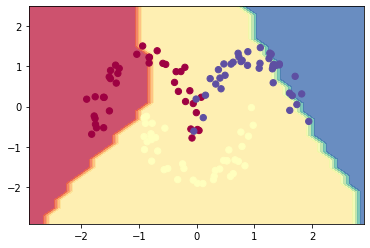

In [ ]:
Z = pred_class.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral, alpha=0.8)
plt.scatter(x_all[:,0], x_all[:,1], c = label_i, s = 40, cmap = plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

Classification performance wasn't too great, likely due to lack of extensive hyperparameter tuning. The complexity of the NN (hundreds of weights) should have bee enough to fit this type of simple boundary.

In [ ]:
import pandas as pd

In [ ]:
pred_class = [max_value_idx(x) for x in preds]
dat = pd.Series(pred_class)
dat.value_counts()

2    81
0    39
dtype: int64

In [ ]:
list(zip(pred_class, label_i))

[(2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (0, 1),
 (2, 1),
 (2, 1),
 (0, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (0, 1),
 (2, 1),
 (0, 1),
 (0, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (2, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (2, 2),
 (0, 2),
 (0, 2),
 (2, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (2, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (2, 2),
 (2, 2),
 (0, 2),
 